Nosso problema consiste em treinar um modelo DQN (Deep Q-Network) para jogar 2048 e atingir o valor 2048.

In [1]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
import random
import math
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import load_model

Estas foram as bibliotecas utilizadas para resolver este problema!
Abaixo, estão todos os códigos utilizados para modelar e treinar a nossa rede neural.

In [2]:
# inicializa um novo jogo
def novo_jogo(n):
    matriz = np.zeros([n,n])
    return matriz

Cria e retorna uma nova matriz n x n preenchida com zeros.
Inicializa o tabuleiro do jogo 2048, onde cada célula vazia é representada por 0.

Lógica: Usa np.zeros (NumPy) para criar uma matriz nula. Por exemplo, novo_jogo(4) cria um tabuleiro 4x4 vazio.

In [3]:
# adiciona 2 ou 4 na matriz
def adiciona_dois(mat):
    celulas_vazias = []
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if(mat[i][j]==0):
                celulas_vazias.append((i,j))
    if(len(celulas_vazias)==0):
        return mat

    par_indices = celulas_vazias[random.randint(0,len(celulas_vazias)-1)]

    prob = random.random()
    if(prob>=0.9):
        mat[par_indices[0]][par_indices[1]]=4
    else:
        mat[par_indices[0]][par_indices[1]]=2
    return mat

Insere aleatoriamente um 2 (90% das vezes) ou um 4 (10% das vezes) em uma célula vazia do tabuleiro.
Simula o comportamento do jogo 2048, que adiciona um novo número a cada jogada.

Lógica:

Percorre a matriz procurando por células com 0 (vazias).

Seleciona aleatoriamente uma das células vazias.

Usa random.random() para gerar uma probabilidade:

≥ 0.9 → insere um 4

< 0.9 → insere um 2

In [4]:
# checa o estado do jogo
def estado_jogo(mat):
    for i in range(len(mat)-1):  # intencionalmente reduzido para verificar as linhas à direita e abaixo
        for j in range(len(mat[0])-1):
            if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                return 'nao terminou'

    for i in range(len(mat)):  # verifica por entradas com zero
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                return 'nao terminou'

    for k in range(len(mat)-1):  # verifica entradas à esquerda/direita na última linha
        if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
            return 'nao terminou'

    for j in range(len(mat)-1):  # verifica entradas acima/abaixo na última coluna
        if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
            return 'nao terminou'

    return 'perdeu'

Verifica o estado atual do jogo, e determina se o jogo ainda pode continuar ou se o jogador perdeu.

Lógica:

Verifica:

Se há células com 0 (jogo ainda pode continuar).

Se há pares de valores adjacentes iguais (movimentos ainda são possíveis).

Se nenhuma das condições acima for satisfeita, retorna 'perdeu'.

In [5]:
# inverte a matriz horizontalmente
def reverter(mat):
    nova=[]
    for i in range(len(mat)):
        nova.append([])
        for j in range(len(mat[0])):
            nova[i].append(mat[i][len(mat[0])-j-1])
    return nova

Inverte horizontalmente cada linha da matriz.
Usada para simular movimentos para direita ou baixo ao reaproveitar a lógica da esquerda.

Lógica:

Para cada linha, os elementos são colocados em ordem inversa (da direita para a esquerda).

In [6]:
# transpõe a matriz
def transpor(mat):
    return np.transpose(mat)

Transpõe a matriz (troca linhas por colunas).
Facilita a reutilização do movimento "para a esquerda" para simular movimentos verticais (cima e baixo).

Lógica:

Cria uma nova matriz onde matriz[i][j] se torna matriz[j][i], um simples np.transpose.

In [7]:
# move todos os valores para a esquerda
def mover_para_esquerda(mat):
    nova = [[0]*4 for _ in range(4)]
    feito = False
    for i in range(4):
        contagem = 0
        for j in range(4):
            if mat[i][j]!=0:
                nova[i][contagem] = mat[i][j]
                if j!=contagem:
                    feito=True
                contagem+=1
    return (nova,feito)

Desloca todos os números da matriz para a esquerda, sem fazer fusões.
Parte da mecânica de movimentação do jogo 2048.

Lógica:

Para cada linha:

Move todos os valores não-zero para o início da linha (esquerda).

Zera o restante.

feito indica se houve movimentação (usado para validar se a jogada foi válida).

In [8]:
# junta valores iguais adjacentes
def mesclar(mat):
    feito=False
    pontuacao = 0
    for i in range(4):
        for j in range(3):
            if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                mat[i][j]*=2
                pontuacao += mat[i][j]
                mat[i][j+1]=0
                feito=True
    return (mat,feito,pontuacao)

Combina células adjacentes com valores iguais (em linha), dobrando o valor da primeira e zerando a segunda.
Representa o comportamento de fusão do jogo 2048.

Lógica:

Para cada linha, compara elementos adjacentes.

Se forem iguais e não forem zero:

Soma os valores (x + x = 2x)

Zera o segundo.

Marca feito=True e acumula pontuação.

In [9]:
# movimento para cima
def cima(jogo):
    jogo = transpor(jogo)
    jogo,feito = mover_para_esquerda(jogo)
    temp = mesclar(jogo)
    jogo = temp[0]
    feito = feito or temp[1]
    jogo = mover_para_esquerda(jogo)[0]
    jogo = transpor(jogo)
    return (jogo,feito,temp[2])

Executa o movimento "para cima".
Aplica movimentação e fusão dos blocos para a direção superior.

Lógica:

Transpõe o tabuleiro (transforma colunas em linhas).

Move valores para a esquerda (que agora representa cima).

Mescla valores.

Move novamente para corrigir zeros no meio.

Transpõe de volta.

In [10]:
# movimento para baixo
def baixo(jogo):
    jogo = reverter(transpor(jogo))
    jogo,feito = mover_para_esquerda(jogo)
    temp = mesclar(jogo)
    jogo = temp[0]
    feito = feito or temp[1]
    jogo = mover_para_esquerda(jogo)[0]
    jogo = transpor(reverter(jogo))
    return (jogo,feito,temp[2])

Executa o movimento "para baixo".
Aplica movimentação e fusão dos blocos para a direção inferior.

Lógica:

Transpõe a matriz.

Inverte horizontalmente (transforma para simular “direita”).

Move e mescla valores.

Reverte e transpõe de volta.

In [11]:
# movimento para a esquerda
def esquerda(jogo):
    jogo,feito = mover_para_esquerda(jogo)
    temp = mesclar(jogo)
    jogo = temp[0]
    feito = feito or temp[1]
    jogo = mover_para_esquerda(jogo)[0]
    return (jogo,feito,temp[2])

Executa o movimento "para a esquerda".
Move e mescla os blocos na direção esquerda.

Lógica:

Move blocos para a esquerda.

Mescla valores.

Move novamente para preencher zeros.

Retorna o novo estado, se houve movimentação e a pontuação ganha.

In [12]:
# movimento para a direita
def direita(jogo):
    jogo = reverter(jogo)
    jogo,feito = mover_para_esquerda(jogo)
    temp = mesclar(jogo)
    jogo = temp[0]
    feito = feito or temp[1]
    jogo = mover_para_esquerda(jogo)[0]
    jogo = reverter(jogo)
    return (jogo,feito,temp[2])


Executa o movimento "para a direita".
Move e mescla os blocos na direção direita.

Lógica:

Inverte cada linha.

Move e mescla valores (como se fosse para a esquerda).

Move novamente e reverte para restaurar o sentido original.

In [13]:
# mapeamento de controles
controles = {0:cima,1:esquerda,2:direita,3:baixo}

Mapeia números inteiros para funções de movimentação.
Fizemos isto pois facilita a chamada dinâmica dos movimentos (ex: IA ou interface gráfica).

In [14]:
# converte o tabuleiro para representação por potências de 2
def alterar_valores(X):
    matriz_potencias = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                matriz_potencias[0][i][j][0] = 1.0
            else:
                potencia = int(math.log(X[i][j],2))
                matriz_potencias[0][i][j][potencia] = 1.0
    return matriz_potencias

# encontra número de células vazias
def encontrar_celulas_vazias(mat):
    cont = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                cont+=1
    return cont

A célula acima, é a parte principal para que o algoritmo de aprendizado de reforço entenda quais são as melhores jogadas,
quais ele deve recompensar mais.

a parte alterar_valores converte o tabuleiro X para uma matriz one-hot representando as potências de 2.
Útil para treinar IA com entrada de redes neurais (por exemplo, em TensorFlow ou PyTorch).

Lógica:

Cria uma matriz 4D com shape (1, 4, 4, 16).

Cada célula de X é convertida em um vetor de 16 posições:

X[i][j] = 2^k → vetor com 1.0 na posição k

Se zero, ativa a posição 0.

a parte encontrar_celulas_vazias conta quantas células têm valor 0 no tabuleiro.
Pode ser usado para decidir se o jogo continua, ou como informação para uma IA (heurística/estratégia para resolver este problema).

Lógica:

Percorre toda a matriz.

Soma todas as posições onde mat[i][j] == 0.

In [15]:
# Hiperparâmetros
taxa_aprendizado_inicial = 0.0005 #taxa inicial de aprendizado do otimizador.
desconto = 0.95 #fator de desconto usado no Q-learning para valorar recompensas futuras.
capacidade_memoria = 6000 #número de experiências armazenadas antes do replay.
profundidade1 = 128 #neuronios para convolução na primeira profundidade
profundidade2 = 128 #neuronios para convolução na segunda profundidade
tamanho_lote = 64 #tamanho do batch usado no treinamento.
unidades_entrada = 16 #dimensão da entrada (4x4x16 = codificação one-hot).
unidades_ocultas = 256 #neurônios na camada densa escondida.
unidades_saida = 4 #número de ações (cima, baixo, esquerda, direita).
M = 300 #número total de episódios de treinamento.

epsilon_inicial = 0.1 #quanto mais perto de 1, mais o modelo explora jogadas
epsilon_final = 0.1 #quanto mais perto de 0, mais o modelo confia naquilo que ele aprendeu
decay_episodios = 1
#Epsilon-Greedy: técnica de exploração/exploração. Começa explorando (ε = 1) e 
#decai para exploração mínima (ε = 0.1) ao longo de 14.000 episódios.

memoria_replay = []
rotulos_replay = []
#armazena transições (estado, ação, recompensa, próximo estado) para experiência repetida (replay buffer), 
#essencial para estabilizar o treinamento em DQN.

In [16]:
inicializador = tf.keras.initializers.HeNormal() #define como os pesos de uma camada são inicializados antes do treinamento começar.
#HeNormal impede um problema chamado (pelo que entendi) de vanishing gradient que aparece aqui

conv1_layer1 = tf.keras.layers.Conv2D(
    filters=profundidade1,
    kernel_size=(1, 2),
    padding='valid',
    activation='relu',
    use_bias=False,
    kernel_initializer=inicializador
)

conv2_layer1 = tf.keras.layers.Conv2D(
    filters=profundidade1,
    kernel_size=(2, 1),
    padding='valid',
    activation='relu',
    use_bias=False,
    kernel_initializer=inicializador
)

conv1_layer2 = tf.keras.layers.Conv2D(
    filters=profundidade2,
    kernel_size=(1, 2),
    padding='valid',
    activation='relu',
    use_bias=False,
    kernel_initializer=inicializador
)

conv2_layer2 = tf.keras.layers.Conv2D(
    filters=profundidade2,
    kernel_size=(2, 1),
    padding='valid',
    activation='relu',
    use_bias=False,
    kernel_initializer=inicializador
)

Define 4 camadas convolucionais com kernel (1x2) e (2x1), aplicadas em diferentes fases do modelo.

Importância: capturam padrões horizontais e verticais no tabuleiro — fundamentais para detectar fusões e alinhamentos úteis.

In [17]:
def construir_modelo(tensor_entrada):
    saida_conv1 = conv1_layer1(tensor_entrada)
    saida_conv2 = conv2_layer1(tensor_entrada)

    saida_conv11 = conv1_layer2(saida_conv1)
    saida_conv12 = conv2_layer2(saida_conv1)
    saida_conv21 = conv1_layer2(saida_conv2)
    saida_conv22 = conv2_layer2(saida_conv2)

    flatten_camadas = [
        tf.keras.layers.Flatten()(saida_conv1),
        tf.keras.layers.Flatten()(saida_conv2),
        tf.keras.layers.Flatten()(saida_conv11),
        tf.keras.layers.Flatten()(saida_conv12),
        tf.keras.layers.Flatten()(saida_conv21),
        tf.keras.layers.Flatten()(saida_conv22),
    ]

    concatenado = tf.keras.layers.Concatenate(axis=-1)(flatten_camadas)
    densa_oculta = tf.keras.layers.Dense(256, activation='relu')(concatenado)
    camada_saida = tf.keras.layers.Dense(4)(densa_oculta)

    return camada_saida

Constrói a rede neural:

Aplica duas convoluções diferentes no input.
Aplica novamente convoluções sobre os mapas intermediários.
Achata todas as saídas (Flatten) e concatena.
Passa por uma camada densa oculta (256 unidades, ReLU).
Saída com 4 neurônios representando os Q-values para cada ação

Finalidade: retorna um vetor com 4 Q-valores (1 para cada movimento possível), o melhor (maior valor) é escolhido para o movimento, excento quanto o epsilon força uma exploração aleatória, ai uma jogada aleatória é feita.

In [18]:
# Construção do modelo com entrada dinâmica
input_tensor = tf.keras.Input(shape=(4, 4, 16))
output_tensor = construir_modelo(input_tensor)
modelo = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)


Esta parte é responsável por compilar o modelo completo com input_tensor de shape (4,4,16) (tabuleiro one-hot).
Forma de entrada: cada célula representa uma potência de 2 codificada com 16 posições (0 a 2^15).

In [19]:
# Otimizador com decaimento exponencial
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=taxa_aprendizado_inicial,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)
otimizador = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
funcao_perda = tf.keras.losses.MeanSquaredError()


ExponentialDecay: taxa de aprendizado decresce com o tempo.

RMSprop: ótimo para problemas com gradientes ruidosos como jogos.

MSE: erro quadrático médio entre Q-targets e Q-preditos.

(Esta parte está no loop de treinamento, mas já adiantando para ficar melhor explicado
Q-predito = É o vetor de Q-valores gerado pela rede atual (predicoes = modelo(lote_dados))
É o vetor de Q-valores corrigido com base na recompensa recebida e no Q-valor futuro estimado: (rotulos[con] = recompensa + desconto * max_qvalue)
Compara Q-target com Q-predito. A rede é treinada para reduzir essa diferença. Ou seja, quanto maior o MSE, pior o treinamento.

In [20]:
maior_bloco_geral = 0
lista_pontuacoes = []
maximo_bloco = 0
melhor_pontuacao = 0
episodio_melhor_pontuacao = 0
perdas = []  # Lista para armazenar as perdas

# Carregar pesos do último treinamento (caso deseje continuar)
modelo = load_model("pesos_ep_4500.keras")
#otimizador = modelo.optimizer
print("Modelo carregado com sucesso.")

Modelo carregado com sucesso.


Permite retomar o treinamento a partir de pesos salvos.

Na célula abaixo, todo o treinamento está feito, e basicamente a lógica é a seguinte:

Define epsilon com decaimento.

Inicializa o tabuleiro.

Loop do jogo até que o estado seja 'perdeu'.


**Para escolher a ação ele testa se**

Se número aleatório < ε:
Explora: seleciona uma ação aleatória dentre as válidas.

Caso contrário:
Exploita: escolhe ação com maior valor-Q.

**rotulos[con] = recompensa + γ * max_qvalue**

Isto gera a recompensa do modelo, que inclui:

Mudança no maior bloco.

Variação nas células vazias.

Q-value futuro estimado (bootstrapping via rede).

**Quando a memoria_replay atinge a capacidade:**

Shuffle da memória.

Divide em lotes (tamanho_lote).

Calcula a perda e aplica backpropagation com GradientTape.

Atualiza os pesos do modelo.


**para monitorar fizemos:**

Monitoramento

A cada 400 iterações, imprime estatísticas de desempenho.

A cada 500 episódios, salva os pesos.

A cada 1000 episódios, mostra resumo.


**Pós-treinamento: Gráfico de pontuação:**

Mostra a evolução da IA ao longo dos episódios.

**No final mostra o melhor score obtido e em qual ep foi alcançado**


╔══════════════════════════════════════════════╗
║ EPISÓDIO:     0
╠══════════════════════════════════════════════╣
║ SCORE:  964.0
║ RESULTADO: PERDEU     
║ ITERAÇÕES:  117
╠══════════════════════════════════════════════╣
║ TABULEIRO FINAL:
║    2   64    4    2
║    8   32    8    4
║    4   64   16   32
║    8    2    4    2
╠══════════════════════════════════════════════╣
║ MAIOR BLOCO:   64
║ MAIOR BLOCO GERAL:    0
╠══════════════════════════════════════════════╣
║ EPSILON: 0.1000
║ TAXA DE APRENDIZADO: 0.0005000000
╚══════════════════════════════════════════════╝


╔══════════════════════════════════════════════╗
║ EPISÓDIO:     1
╠══════════════════════════════════════════════╣
║ SCORE: 5376.0
║ RESULTADO: PERDEU     
║ ITERAÇÕES:  371
╠══════════════════════════════════════════════╣
║ TABULEIRO FINAL:
║    4    8   64    2
║    2  128   16   32
║    4  512   32    2
║    2    8    2    8
╠══════════════════════════════════════════════╣
║ MAIOR BLOCO:  512
║ MAIOR BLOCO GERAL

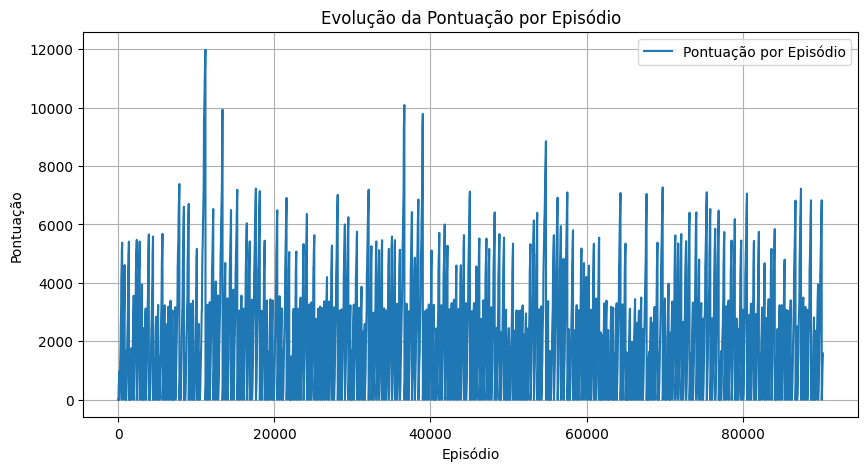


╔══════════════════════════════════════════════╗
║ TREINAMENTO CONCLUÍDO
╠══════════════════════════════════════════════╣
║ MELHOR SCORE OBTIDO: 11980.0
║ NO EPISÓDIO:    39
╚══════════════════════════════════════════════╝



In [21]:
# Loop de treinamento
for ep in range(M):

    if ep <= decay_episodios:
        epsilon = epsilon_inicial - ((ep / decay_episodios) ** 1.5) * (epsilon_inicial - epsilon_final)
    else:
        epsilon = epsilon_final
    
    tabuleiro = novo_jogo(4)
    adiciona_dois(tabuleiro)
    adiciona_dois(tabuleiro)
    fim = 'nao terminou'
    pontuacao_total = 0
    iter_local = 1

    while fim == 'nao terminou':
        tabuleiro_ant = np.copy(tabuleiro) #Garante uma cópia do tabuleiro antes da ação, para comparações posteriores. Importante para Q-values
        estado = alterar_valores(tabuleiro_ant)
        estado = np.array(estado, dtype=np.float32).reshape(1, 4, 4, 16) #one-hot
        pontuacoes_controle = modelo(estado)
        pontuacoes_controle = pontuacoes_controle.numpy() #a rede neural prediz os Q-valores a partir daqui
        botoes_controle = np.flip(np.argsort(pontuacoes_controle), axis=1) #retorna os indices do Q-valor (do maior ao menor)
        rotulos = deepcopy(pontuacoes_controle[0]) #Começa a entroncar os Q-valores (ainda não é predito nem target, só Q-valores)
        num = random.uniform(0, 1) #sorteio aleatório para decidir se vai explorar ou explorar.
        max_ant = np.max(tabuleiro_ant) #guarda o maior bloco antes da jogada, para avaliar recompensa depois.

        if num < epsilon: #Se ele preferir explorar (epsilon grande), este código roda
            movimentos_legais = []
            for i in range(4):
                temp_tabuleiro = np.copy(tabuleiro_ant)
                temp_tabuleiro, _, _ = controles[i](temp_tabuleiro)
                if not np.array_equal(temp_tabuleiro, tabuleiro_ant):
                    movimentos_legais.append(i) #Testa cada ação possível, e só guarda as ações que realmente mudam o tabuleiro (movimentos válidos).
            if not movimentos_legais:
                fim = 'perdeu'
                continue #o jogo acabou, eu ruim fml
            con = random.choice(movimentos_legais) #escolhe um movimento aleatório que pode ser feito
            temp_estado = np.copy(tabuleiro_ant)
            temp_estado, _, score = controles[con](temp_estado)
            pontuacao_total += score #Aplica a ação ao tabuleiro e acumula a pontuação da jogada (caso tenha pontos acumulados)
            fim = estado_jogo(temp_estado) #verifica se o jogo acabou ou ainda tem mais
            vazios1 = encontrar_celulas_vazias(tabuleiro_ant)
            vazios2 = encontrar_celulas_vazias(temp_estado) #Encontra os valores para o calculo das recompensas do modelo (já é parte do Q-target)
            if fim == 'nao terminou':
                temp_estado = adiciona_dois(temp_estado) #adiciona outro valor no tabuleiro caso o jogo não tenha acabado (adiciona 2 ou 4)
            tabuleiro = deepcopy(temp_estado) #atualiza o tabuleiro original com as jogadas feitas
            max_novo = np.max(temp_estado)
            rotulos[con] = (math.log(max_novo, 2)) * 0.1 if max_novo > max_ant else 0
            rotulos[con] += (vazios2 - vazios1) #calcula a recompensa que o modelo terá por estas jogadas
            temp_estado = alterar_valores(temp_estado)
            temp_estado = np.array(temp_estado, dtype=np.float32).reshape(1, 4, 4, 16)
            temp_scores = modelo(temp_estado)
            max_qvalue = np.max(temp_scores.numpy())
            rotulos[con] += desconto * max_qvalue #Calcula o Q-valor futuro estimado pelo modelo no novo estado, e aplica o fator de desconto γ.
            #aqui, rotulos[con] já é o Q-target
        else: #Escolhe a melhor ação com o maior Q-valor predito pela rede
            for con in botoes_controle[0]: #Percorre as ações em ordem de melhor Q-valor (da maior para a menor), tentando encontrar a primeira válida.
                estado_ant = np.copy(tabuleiro_ant)
                temp_estado, _, score = controles[con](estado_ant)
                if np.array_equal(tabuleiro_ant, temp_estado):
                    rotulos[con] = 0
                    continue #ignora basicamente as ações inválidas, jogadas que não podem ser feitas no jogo
                vazios1 = encontrar_celulas_vazias(tabuleiro_ant) #daqui até o break é igualzinho ao código acima
                vazios2 = encontrar_celulas_vazias(temp_estado)
                temp_estado = adiciona_dois(temp_estado)
                tabuleiro = deepcopy(temp_estado)
                pontuacao_total += score
                max_novo = np.max(temp_estado)
                rotulos[con] = (math.log(max_novo, 2)) * 0.1 if max_novo > max_ant else 0
                rotulos[con] += (vazios2 - vazios1)
                temp_estado = alterar_valores(temp_estado)
                temp_estado = np.array(temp_estado, dtype=np.float32).reshape(1, 4, 4, 16)
                temp_scores = modelo(temp_estado)
                max_qvalue = np.max(temp_scores.numpy())
                rotulos[con] += desconto * max_qvalue
                break 
            if np.array_equal(tabuleiro_ant, tabuleiro):
                fim = 'perdeu' #checa se perdeu

        estado_ant = alterar_valores(tabuleiro_ant)
        estado_ant = np.array(estado_ant, dtype=np.float32).reshape(1, 4, 4, 16)
        rotulos_replay.append(rotulos)
        memoria_replay.append(estado_ant) #aqui é armazenado o jogo no replay buffer (principal motivo do código sucumbir +16gb de ram)

        if len(memoria_replay) >= capacidade_memoria: #treinamento em mini-batches
            perda_retro = 0 #loss
            num_lotes = 0 #numero de mini-batches 
            z = list(zip(memoria_replay, rotulos_replay))
            random.shuffle(z) #Embaralha os dados para evitar correlação e viés da rede neural
            memoria_replay, rotulos_replay = zip(*z) #Divide em mini-lotes.
            for i in range(0, len(memoria_replay), tamanho_lote): #Treinamento em lotes
                if i + tamanho_lote > len(memoria_replay):
                    break
                lote_dados = np.array(memoria_replay[i:i + tamanho_lote], dtype=np.float32).reshape(tamanho_lote, 4, 4, 16) 
                #esta parte são os tabuleiros que serão usados como entrada na rede
                lote_rotulos = np.array(rotulos_replay[i:i + tamanho_lote], dtype=np.float32).reshape(tamanho_lote, unidades_saida)
                #os Q-targets esperados (um vetor de 4 valores para cada ação possível). E usados no float32 pra ocupar menos espaço
                with tf.GradientTape() as tape: #Nossa função perda
                    predicoes = modelo(lote_dados) #O maior Q-target esperado para o modelo
                    perda = funcao_perda(lote_rotulos, predicoes) #MSE do maior Q-target e o Q-predito
                gradientes = tape.gradient(perda, modelo.trainable_variables) #Calcula os gradientes da perda em relação aos pesos do modelo
                otimizador.apply_gradients(zip(gradientes, modelo.trainable_variables)) #aplica os gradientes aos pesos da rede
                perda_retro += perda.numpy() #Soma o valor da perda desse mini-batch ao total.
                num_lotes += 1
            perda_retro /= num_lotes
            perdas.append(perda_retro)  #Calcula a média da perda por lote nesse ciclo de treinamento.
            memoria_replay = [] #Salva a perda para plotar gráfico e monitorar tudo
            rotulos_replay = []

        if iter_local % 400 == 0:
            print(f"Episódio: {ep}, Pontuação: {pontuacao_total}, Iterações: {iter_local}, Estado: {fim}") 
        lista_pontuacoes.append(pontuacao_total)
        if maximo_bloco > maior_bloco_geral: #guarda a pontuação e o maior bloco até agora
            maior_bloco_geral = maximo_bloco

        iter_local += 1

        if ep % 500 == 0: #salva o modelo a cada 500 episódios
            modelo.save(f"pesos_ep_{ep}.keras")

    maximo_bloco = int(np.max(tabuleiro))

    # Saída formatada para cada episódio, para analisar como está indo o treino enquanto o código está ativo (muito importante, pois nunca consegui
    # rodar o código todo até o final pois o modelo precisa +16gb de ram e uma placa de vídeo, coisas que não tenho...)
    print(f"""
╔══════════════════════════════════════════════╗
║ EPISÓDIO: {ep:5d}
╠══════════════════════════════════════════════╣
║ SCORE: {pontuacao_total:6.1f}
║ RESULTADO: {fim.upper():<11}
║ ITERAÇÕES: {iter_local:4d}
╠══════════════════════════════════════════════╣
║ TABULEIRO FINAL:
║ {tabuleiro[0][0]:4.0f} {tabuleiro[0][1]:4.0f} {tabuleiro[0][2]:4.0f} {tabuleiro[0][3]:4.0f}
║ {tabuleiro[1][0]:4.0f} {tabuleiro[1][1]:4.0f} {tabuleiro[1][2]:4.0f} {tabuleiro[1][3]:4.0f}
║ {tabuleiro[2][0]:4.0f} {tabuleiro[2][1]:4.0f} {tabuleiro[2][2]:4.0f} {tabuleiro[2][3]:4.0f}
║ {tabuleiro[3][0]:4.0f} {tabuleiro[3][1]:4.0f} {tabuleiro[3][2]:4.0f} {tabuleiro[3][3]:4.0f}
╠══════════════════════════════════════════════╣
║ MAIOR BLOCO: {maximo_bloco:4.0f}
║ MAIOR BLOCO GERAL: {maior_bloco_geral:4.0f}
╠══════════════════════════════════════════════╣
║ EPSILON: {epsilon:.4f}
║ TAXA DE APRENDIZADO: {otimizador.learning_rate.numpy():.10f}
╚══════════════════════════════════════════════╝
""")

    if (ep+1) % 1000 == 0:
        ultima_perda = f"{perdas[-1]:.6f}" if perdas else "N/A"
        print(f"""
╔══════════════════════════════════════════════╗
║ RESUMO A CADA 1000 EPISÓDIOS
╠══════════════════════════════════════════════╣
║ MELHOR SCORE: {melhor_pontuacao:6.1f}
║ EPISÓDIO DO MELHOR SCORE: {episodio_melhor_pontuacao:5d}
╠══════════════════════════════════════════════╣
║ ÚLTIMA PERDA: {ultima_perda}
╚══════════════════════════════════════════════╝
""")

    if melhor_pontuacao < pontuacao_total:
        melhor_pontuacao = pontuacao_total
        episodio_melhor_pontuacao = ep

# Gráfico das pontuações
plt.figure(figsize=(10, 5))
plt.plot(lista_pontuacoes, label='Pontuação por Episódio')
plt.xlabel("Episódio")
plt.ylabel("Pontuação")
plt.title("Evolução da Pontuação por Episódio")
plt.grid(True)
plt.legend()
plt.show()

#Infelizmente nunca vi o gráfico porque o meu pc não conseguia ir até o fim dos treinamentos.

print(f"""
╔══════════════════════════════════════════════╗
║ TREINAMENTO CONCLUÍDO
╠══════════════════════════════════════════════╣
║ MELHOR SCORE OBTIDO: {melhor_pontuacao:6.1f}
║ NO EPISÓDIO: {episodio_melhor_pontuacao:5d}
╚══════════════════════════════════════════════╝
""")